# Install necessary functions


In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import load_img, resample_to_img, index_img
from nilearn.masking import intersect_masks, apply_mask, unmask
from nilearn.signal import clean
from nilearn.interfaces.fmriprep import load_confounds
import glob
import re
import matplotlib.pyplot as plt


## Set User Parameters

In [2]:
# -----------------------------------------------------------------------------
# 1) USER PARAMETERS
# -----------------------------------------------------------------------------

# Where your fmriprep lives
base_dir    = '/Volumes/Passport/fmriprep'
task_label  = 'pieman'
output_mask = os.path.join(base_dir,
                           f'group_task-{task_label}_intersect_mask.nii.gz')

# TR indices to keep
tr_slice = slice(13, 173)
TR = 1.5

# Exclusions
exclude_subs     = {'sub-001','sub-021','sub-022','sub-038','sub-056','sub-068','sub-069'}
exclude_sub_runs = {('sub-002','2'),('sub-003','2'),('sub-004','2'),
                    ('sub-005','2'),('sub-006','2'),('sub-008','2'),
                    ('sub-010','2'),('sub-011','2'),('sub-012','2'),
                    ('sub-013','2'),('sub-014','2'),('sub-015','2'),
                    ('sub-016','2')}

# Which BOLD space / resolution to use
preferred_space = 'MNI152NLin2009cAsym'
preferred_res   = 'native'

# *** New: set this if you only want to process one subject ***
# e.g. target_subject = 'sub-002' 
# or target_subject = None  to run on all (minus excluded)
target_subject = 'sub-002'


intersect = load_img(os.path.join(base_dir, 'derivatives','pieMan_masks','group_task-pieman_intersect_mask.nii.gz'))




## Set subjects list

In [3]:
# -----------------------------------------------------------------------------
# 2) BUILD LIST OF SUBJECTS
# -----------------------------------------------------------------------------
all_subs = sorted(d for d in os.listdir(base_dir)
                  if d.startswith('sub-')
                  and os.path.isdir(os.path.join(base_dir, d)))
if target_subject:
    if target_subject not in all_subs:
        raise ValueError(f"{target_subject} not found under {base_dir}")
    subjects = [target_subject]
else:
    subjects = [s for s in all_subs if s not in exclude_subs]

## Process Bold Run/Clean the timeseries signal

In [4]:
# -----------------------------------------------------------------------------
# 4) PROCESS EACH VALID BOLD RUN (native‑res, already aligned)
# -----------------------------------------------------------------------------
space_res = f"space-{preferred_space}_res-{preferred_res}"

for sub in subjects:
    func_dir = os.path.join(base_dir, sub, "func")
    # collect preproc BOLD files
    run_pat    = os.path.join(func_dir,
                   f"{sub}_task-{task_label}_run-*_{space_res}_desc-preproc_bold.nii.gz")
    single_pat = os.path.join(func_dir,
                   f"{sub}_task-{task_label}_{space_res}_desc-preproc_bold.nii.gz")
    bold_files = sorted(glob.glob(run_pat)) + sorted(glob.glob(single_pat))
    if not bold_files:
        print(f"Skipping {sub}: no preproc BOLD")
        continue

    for bf in bold_files:
        run_m = re.search(r"_run-(\d+)_", os.path.basename(bf))
        run   = run_m.group(1) if run_m else None
        if run and (sub,run) in exclude_sub_runs:
            print(f"  • skipping {sub} run-{run}")
            continue

        # flexible confounds lookup
        if run:
            conf_pat = os.path.join(func_dir,
                f"{sub}_task-{task_label}_run-{run}_desc-confounds*.tsv")
        else:
            conf_pat = os.path.join(func_dir,
                f"{sub}_task-{task_label}_desc-confounds*.tsv")

        confs = sorted(glob.glob(conf_pat))
        if not confs:
            print(f" Missing confounds for {os.path.basename(bf)} → skipping")
            continue
        conf_file = confs[0]

        print(f"\nProcessing {sub}{'_run-'+run if run else ''}: {os.path.basename(bf)}")
        bold_img = load_img(bf)

        # ── SANITY CHECK alignment ─────────────────────────────────────────────
        # Make sure shapes and affines exactly match the intersect mask; otherwise skip.
        if bold_img.shape[:3] != intersect.shape:
            print(f"  !! shape mismatch: bold {bold_img.shape[:3]} vs mask {intersect.shape} → skipping")
            continue
        if not np.allclose(bold_img.affine, intersect.affine):
            print("  !! affine mismatch → skipping")
            continue
        # ─────────────────────────────────────────────────────────────────────────



        # -----------------------------------------------------------------------------
        # LOAD CONFOUNDS via nilearn’s fmriprep interface
        # -----------------------------------------------------------------------------
        print("Loading confounds…")
        confounds_df, sample_mask = load_confounds(
        img_files    = bf,
        strategy     = ('motion', 'high_pass', 'wm_csf'),
        motion       = 'full',
        wm_csf       = 'basic',
        global_signal= 'basic',
        compcor      = 'anat_combined',
        n_compcor    = 'all',
        ica_aroma    = 'full',
        scrub        = 5,
        fd_threshold = 0.2,
        std_dvars_threshold = 3,
        demean       = True
        )

        
        #   clean up infinities / NaNs
        # confounds_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        # confounds_df.fillna(0, inplace=True)


        # extract TR and mask‐then‐clean
        tr = float(bold_img.header.get_zooms()[3])
        ts = apply_mask(bold_img, intersect)
        assert tr == 1500, f"TR mismatch: {tr} vs 1500"
        print("shape of time series:", ts.shape)
        assert ts.shape == (300,43981), f'unexpected shape {ts.shape} should be (300,43981)' 


        # full‐length clean with every kwarg spelled out
        ts_clean = clean(
        signals         = ts,
        runs            = None,
        detrend         = True,
        standardize     = 'zscore_sample',    # use sample‐std zscore
        sample_mask     = None,
        confounds       = confounds_df,
        standardize_confounds = 'zscore_sample',
        low_pass        = 0.1,
        high_pass       = 0.01,
        t_r             = TR,
        ensure_finite   = True,
        )

        # back to 4D NIfTI
        cleaned_img = unmask(ts_clean, intersect)

        # now select only our TR window via index_img
        sel_img = index_img(cleaned_img, tr_slice)

        # --- ADD THIS LINE to fix TR in the header ---
        sel_img.header.set_zooms(sel_img.header.get_zooms()[:3] + (TR,))

        # sanity check: should be 160 TRs
        assert sel_img.shape == (65,77,49,160), f'unexpected shape {sel_img.shape} should be (65,77,49,160)' 


        # save into derivatives/pieMan_cleaned
        run_tag   = f"_run-{run}" if run else ""
        deriv_dir = os.path.join(base_dir, "derivatives", "pieMan_cleaned")
        out_dir   = os.path.join(deriv_dir, sub, "func")
        os.makedirs(out_dir, exist_ok=True)

        out_file = os.path.join(out_dir,
                     f"{sub}_task-{task_label}{run_tag}_cleaned_desc-masked_bold.nii.gz")
        sel_img.to_filename(out_file)
        print("  → saved to:", out_file)
          

print("\nALL DONE.")


Processing sub-002_run-1: sub-002_task-pieman_run-1_space-MNI152NLin2009cAsym_res-native_desc-preproc_bold.nii.gz
Loading confounds…
shape of time series: (300, 43981)
  → saved to: /Volumes/Passport/fmriprep/derivatives/pieMan_cleaned/sub-002/func/sub-002_task-pieman_run-1_cleaned_desc-masked_bold.nii.gz
  • skipping sub-002 run-2

ALL DONE.


## Optional Visualize and Voxel Count for sanity check 

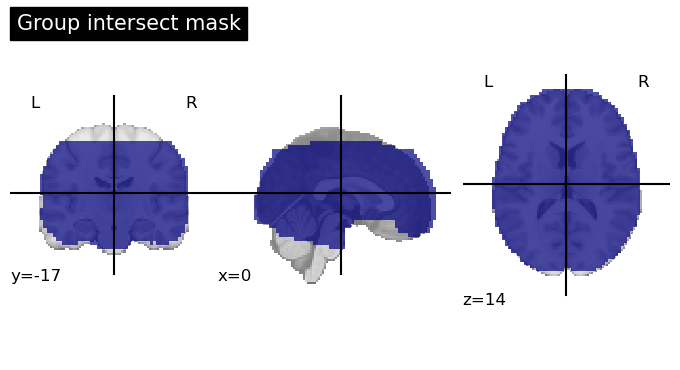

In [9]:
from nilearn.plotting import plot_roi
plot_roi(intersect, title='Group intersect mask')

In [10]:
import numpy as np
import nibabel as nib
grp = intersect.get_fdata().astype(bool)
print("Group mask voxels:", grp.sum())

Group mask voxels: 43981


## Pre-clean vs. Post-clean voxel timeseries

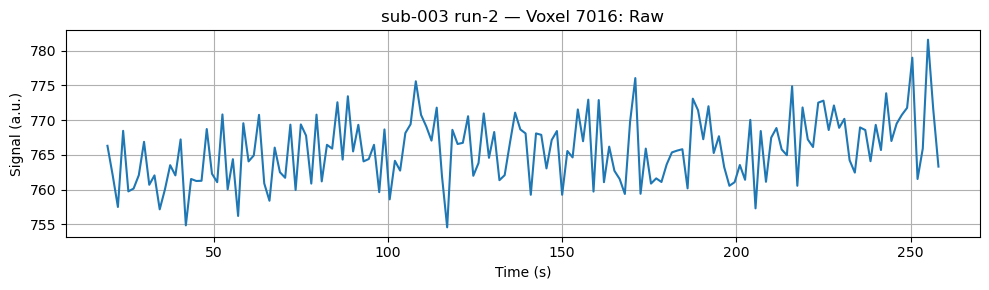

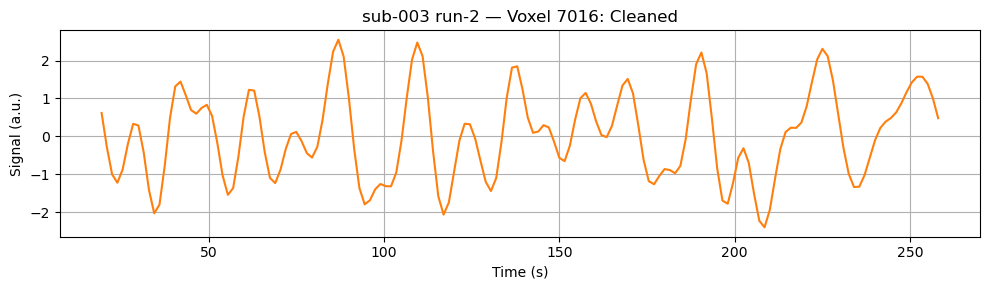

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 1) extract just the window you processed
X_raw = ts[tr_slice, :]       # (n_TRs_sub, n_voxels)
X_cln = ts_clean[tr_slice, :] # same shape

n_TRs_sub, n_vox = X_raw.shape

# 2) build a time axis in seconds
time_axis = np.arange(n_TRs_sub) * TR + (tr_slice.start * TR)

# 3) choose a single voxel (random or fixed)
v_idx = np.random.randint(n_vox)   # or set v_idx = 42

# 4) Plot raw on its own figure
plt.figure(figsize=(10, 3))
plt.plot(time_axis, X_raw[:, v_idx], color='tab:blue')
plt.title(f"{sub} run-{run} — Voxel {v_idx}: Raw")
plt.xlabel("Time (s)")
plt.ylabel("Signal (a.u.)")
plt.grid(True)
plt.tight_layout()

# 5) Plot cleaned on its own figure
plt.figure(figsize=(10, 3))
plt.plot(time_axis, X_cln[:, v_idx], color='tab:orange')
plt.title(f"{sub} run-{run} — Voxel {v_idx}: Cleaned")
plt.xlabel("Time (s)")
plt.ylabel("Signal (a.u.)")
plt.grid(True)
plt.tight_layout()

plt.show()